# Binarizing Document Images with Otsu Thresholding

In [1]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def load_grayscale(path):
    # load an image in grayscale 
    img = Image.open(path).convert("L")
    return np.array(img, dtype = np.uint8)

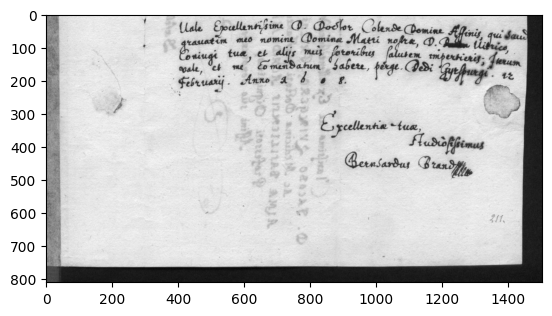

In [3]:
# lets implement otsu thresholding from scratch with lots of experimentation 

sample_path = "..\\Datasets\\dataset\\1.bmp"
sample = load_grayscale(sample_path)
plt.imshow(sample, cmap = "gray")

### Otsu Thresholding Formulation 


We first need to create a histogram of pixels from an image. This is the probability distribution of pixel intensities with 'L' Bins


There are two classes C0 (Background) and C1 (Foreground)
let 't' be the Otsu Threshold, C0 contains 0 to t-1 pixels (`<t` pixels) and C1 contains t to L-1 Pixels (`>=t` pixels)



Goal : Global Search for optimal t* such that intra class variance is minimized (Variance of C0 C1 pixel intensities)



let w0 be cumulative probability of C0 and w1 be the cumulative probability of C1



w0(t) = summation i = 0 to t-1 P(i) 



w1(t) = summation i = t to L-1 P(i) 



Probability of selecting ith pixel from C0 or C1 is : 



P(i|C0) and P(i|C1) Respectively



let mu0(t) and mu1(t) be the mean of C0 and C1 pixel intensities 


mu0(t) = summation i = 0 to t-1 i * P(i|C0) ==> summation i = 0 to t-1 (iP(i)/w0(t))


mu1(t) = summation i = t to L-1 i * P(i|C1) ==> summation i = t to L-1 (iP(i)/w1(t))



Now Variances Sigma Square 0 and 1 of t are given by : 


Sigma zero square(t) = summation i = 0 to t-1 (P(i|C0) * (i - mu0(t))^2)


Sigma one square(t) = summation i = t to L-1 (P(i|C1) * (i - mu1(t))^2)



Now let Sigma b square (t) = sigma T square (Total Histogram Variance) - [w0(t) sigma zero square(t) + w1(t) sigma one square(t)]

==> w0w1 ((mu0 - mu1)^2)


therefore, we get : 

sigma b square(t) = max sigma b square(t) w.r.t t -> `0<t<L`

[    0     0     0     0     0     0     0     0     0     5     2     6
    15    33    56    86   127   190   225   286   304   346   401   541
   667  1016  1646  2640  4186  6069  8147  9758 10472 10285  9994  8769
  7474  6447  4986  3807  2973  2086  1495  1244  1031   882   926   921
   964   985  1083  1094  1126  1154  1172  1164  1205  1211  1185  1148
  1138  1088  1049  1020   925   987   909   836   898   797   845   833
   850   843   853   770   813   757   675   648   602   581   570   553
   511   539   523   572   498   461   489   480   505   453   488   479
   476   445   469   527   494   490   528   522   542   512   537   559
   552   559   604   677   715   701   752   813   843   922   950  1024
  1123  1156  1164  1289  1321  1390  1403  1471  1610  1658  1556  1657
  1779  1763  1695  1685  1624  1647  1538  1574  1515  1418  1328  1224
  1142  1144   965   898   953   887   779   765   771   739   712   727
   702   762   736   794   799   831   906   938   

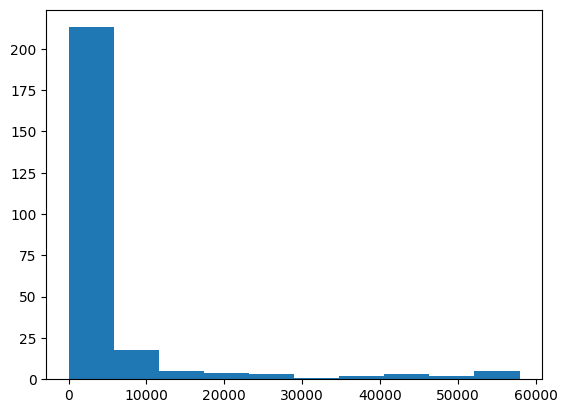

In [7]:
hist, bin_edges = np.histogram(sample.ravel(), bins = 256, range= (0,256))
plt.hist(hist)
print(hist)
print(bin_edges)

### Plan of Action for finding Otsu Threshold

* Compute pixel intensities and normalize them (divide by total no. of pixels)

* loop from k = 0 to 255

* compute class probabilities (Weights) for each k. 

* Find the total probability of background and foreground pixels 

* Find the Class Means (Mean intensities of bg and fg pixels) 

* Calculate between class variance (sigma 2 b)
Sigma square b (k) = class probabilities * (mean(bg) - mean(fg))^2

* Find the maximum between class variance (Argmax)

In [14]:
total_pixels = sample.size 
print(total_pixels) # image size

# normalization of histogram of pixels from the image for Otsu Thresholding
prob = hist / total_pixels 

# print(prob)
# print(prob.shape)

1219744


0.12417960703375465
0.17328142518403394
0.3188859896354194
0.678682591929689
1.4610393635255317
2.7731938927814195
4.76472125124094
7.671252477783324
11.96873575578214
16.99832197821709
23.316675360380025
29.95396617089033
37.41942279344166
45.96985050434589
57.370938707803205
71.26565226507287
92.19442843392234
125.74883748481328
179.0778236703471
263.0417586630007
384.25892205729946
546.8254284772323
741.9663626022162
952.2828080132921
1159.851697107553
1362.480293147547
1540.8836912111465
1693.1424149956479
1824.3916627763087
1925.6067596924704
2002.4822225154167
2062.0886546726365
2103.5443877911566
2132.9508497468546
2157.1475452886043
2176.966329296933
2193.7139867097617
2211.078018588867
2228.130953431867
2245.753198349666
2263.5286512016464
2282.8213456265007
2302.058365412086
2321.6000320368416
2341.3645304130378
2361.1712090856736
2380.57876047494
2400.397592832253
2420.042680282568
2438.9991990032154
2457.1042699887475
2474.7936007503736
2491.458074783844
2507.2849623821958


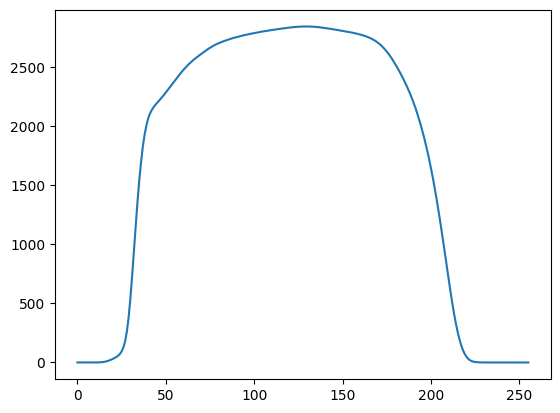

In [22]:
variances = []

for k in range(0,256): 
    # first k elements = C0
    # k+1 to rest elements = C1
    bg_class = hist[:k+1]
    fg_class = hist[k+1:]
    
    # Calculate Class Probabilities of bg_class and fg_class 
    w0 = bg_class.sum() / hist.sum()
    w1 = fg_class.sum() / hist.sum() 

    if bg_class.sum() == 0 or fg_class.sum() == 0:
        variances.append(0)
        continue

    # Calculate mean of C0 and C1
    mu0 = np.sum(np.arange(0, k+1) * bg_class) / bg_class.sum()
    mu1 = np.sum(np.arange(k+1, 256) * fg_class) / fg_class.sum()

    # base class variance 
    sigma_b_squared = w0 * w1 * ((mu0 - mu1) ** 2)
    print(sigma_b_squared)
    variances.append(sigma_b_squared)
    
best_k = np.argmax(variances)
print("optimal threshold ", best_k)

plt.plot(variances)
    # print(bg_class)
    # print(C0) 

    # print(fg_class)
    # print(C1)
    

In [23]:
binary = (sample > best_k).astype(np.uint8) 

print(binary)

[[0 1 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


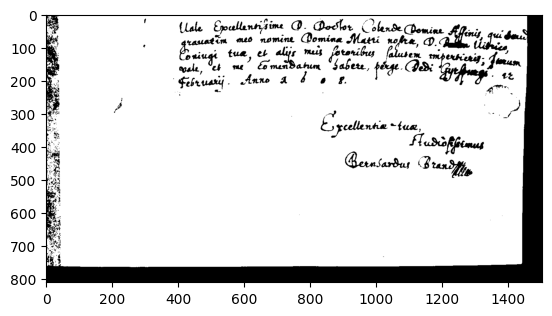

In [27]:
plt.imshow(binary, cmap = "gray")
plt.imsave("..\\Datasets\\outputs\\1_pred.bmp", binary, cmap = "gray")

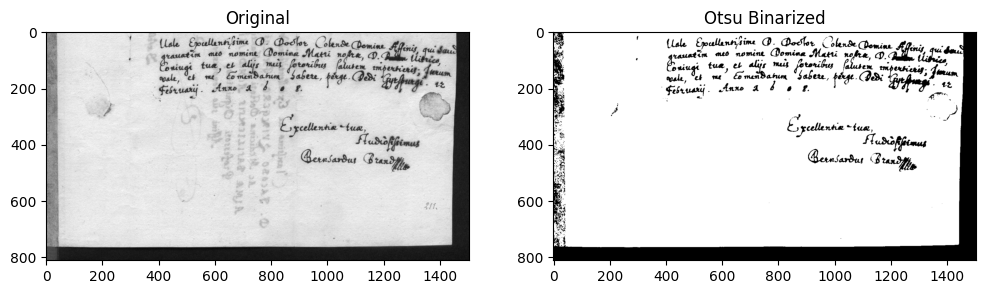

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(sample, cmap='gray')

plt.subplot(1,2,2)
plt.title("Otsu Binarized")
plt.imshow(binary, cmap='gray')
plt.show()